In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Package

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

In [3]:
import nltk
import gensim.downloader

from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten

In [5]:
os.chdir('/content/drive/Shareddrives/NYCU/1101/DataMining/HW4_309652008_廖家緯')

# Data Preprocessing

In [6]:
df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Eliminate stop word

In [7]:
nltk.download('stopwords')

def transforms(sentence):
  words = re.sub('[^a-zA-Z]',' ', sentence.lower()).split()
  stop_words = set(stopwords.words("english"))
  words = [w for w in words if not w in stop_words]

  return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data = pd.DataFrame([])
# data.loc[:, 'sentence'] = df['text'].map(lambda x: re.sub(r'[0-9\.\-\!\"\(\)\,:]', '', x.lower()).split())
data.loc[:, 'sentence'] = df['text'].map(transforms)
data.loc[:, 'label'] = df['stars'].map(lambda x: int(x>=4))
data.head()

,sentence,label
0,"[wife, took, birthday, breakfast, excellent, w...",1
1,"[idea, people, give, bad, reviews, place, goes...",1
2,"[love, gyro, plate, rice, good, also, dig, can...",1
3,"[rosie, dakota, love, chaparral, dog, park, co...",1
4,"[general, manager, scott, petello, good, egg, ...",1


In [9]:
sentence_length = data['sentence'].map(lambda x: len(x))
sentence_length.describe()

count    10000.000000
mean        65.359100
std         56.089644
min          0.000000
25%         27.000000
50%         50.000000
75%         86.000000
max        500.000000
Name: sentence, dtype: float64

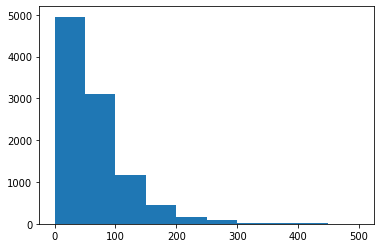

In [10]:
plt.hist(sentence_length)
plt.show()

In [11]:
X_train_word, X_test_word, y_train, y_test = train_test_split(data.sentence, data.label, test_size=0.2, random_state=42)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_word)

In [13]:
max_length = 150
vocab_size = len(tokenizer.word_index)+1
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_word), maxlen=max_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_word), maxlen=max_length)

print(f'shape of training data: {X_train.shape}')
print(f'shape of test data: {X_test.shape}')
print(f'maximum index: {vocab_size}')
print(f'maximum index of training data: {np.max(X_train)}')

shape of training data: (8000, 150)
shape of test data: (2000, 150)
maximum index: 25873
maximum index of training data: 25872


In [14]:
example = [['my', 'wife', 'took', 'me', 'here']]
pad_sequences(tokenizer.texts_to_sequences(example), maxlen=10)

array([[  0,   0,   0,   0,   0,   0,   0,   0, 348, 135]], dtype=int32)

## Word to Vector

In [15]:
def get_similar_word(w2v_model, words, topn=10):
  similar_df = pd.DataFrame()
  for word in words:
    try:
      similar_words = pd.DataFrame(
          w2v_model.wv.most_similar(word, topn=topn),
          columns=[word, 'cos'])
      
      similar_df = pd.concat([similar_df, similar_words], axis=1)
    
    except:
      print(word, "not found in Word2Vec model!")
  
  return similar_df

In [16]:
w2v_pretrain = False
w2v_pretrain_name = None
embedding_dim = 250

In [17]:
if w2v_pretrain:
  w2v_model = Word2Vec.load(w2v_pretrain_name)

else:
  w2v_model = Word2Vec(X_train_word, min_count=1, size=embedding_dim, iter=10, sg=1)
  w2v_model.save('w2v_model_weight.pth')

In [18]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

25873

In [19]:
get_similar_word(w2v_model, ['my', 'wife', 'took', 'me', 'here'])[:5]

my not found in Word2Vec model!
me not found in Word2Vec model!
here not found in Word2Vec model!


,wife,cos,took,cos
0,dad,0.712222,taking,0.671477
1,husbands,0.710834,taken,0.626055
2,bf,0.704333,takes,0.601978
3,bday,0.683275,placing,0.594645
4,brother,0.681257,threw,0.573822


In [20]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(25873, 250)


In [21]:
for word, i in tokenizer.word_index.items():
  print(word, i)
  if i == 10: break

good 1
place 2
food 3
great 4
like 5
one 6
get 7
go 8
time 9
really 10


# Training step

## CNN Model

In [22]:
cnn_model = Sequential()

embedding_layer = Embedding(
    vocab_size, embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False)

cnn_model.add(embedding_layer)
cnn_model.add(Dropout(0.5))
cnn_model.add(Conv1D(128, 16, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(128, 16, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(128, 16, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(2, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 250)          6468250   
                                                                 
 dropout (Dropout)           (None, 150, 250)          0         
                                                                 
 conv1d (Conv1D)             (None, 135, 128)          512128    
                                                                 
 dropout_1 (Dropout)         (None, 135, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 128)          262272    
                                                                 
 dropout_2 (Dropout)         (None, 120, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 105, 128)          2

In [23]:
def lr_schedule(epoch, lr):
  if epoch % 5 == 4:
    lr *= 0.8
 
  return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [24]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [25]:
cnn_record = cnn_model.fit(
    X_train, y_train,
    batch_size=1024, epochs=30,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1)

Epoch 1/30
7/7 [==============================] - 8s 590ms/step - loss: 0.8226 - accuracy: 0.6583 - val_loss: 0.6470 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - 3s 381ms/step - loss: 0.6607 - accuracy: 0.6648 - val_loss: 0.6298 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - 3s 380ms/step - loss: 0.6325 - accuracy: 0.6798 - val_loss: 0.6126 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - 3s 381ms/step - loss: 0.6021 - accuracy: 0.6805 - val_loss: 0.5706 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 3s 380ms/step - loss: 0.5582 - accuracy: 0.7020 - val_loss: 0.5174 - val_accuracy: 0.7356 - lr: 8.0000e-04
Epoch 6/30
7/7 [==============================] - 3s 379ms/step - loss: 0.5108 - accuracy: 0.7422 - val_loss: 0.4827 - val_accuracy: 0.7631 - lr: 8.0000e-04
Epoch 7/30
7/7 [==============================] - 3s 381ms/step - loss: 0.

## LSTM Model

In [26]:
lstm_model = Sequential()

embedding_layer = Embedding(
    vocab_size, embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 250)          6468250   
                                                                 
 dropout_3 (Dropout)         (None, 150, 250)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               140400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,608,751
Trainable params: 140,501
Non-trainable params: 6,468,250
_________________________________________________________________


In [27]:
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [28]:
lstm_record = lstm_model.fit(
    X_train, y_train,
    batch_size=1024, epochs=30,
    validation_split=0.2, verbose=1)

Epoch 1/30
7/7 [==============================] - 11s 1s/step - loss: 0.6328 - accuracy: 0.6756 - val_loss: 0.5980 - val_accuracy: 0.6931
Epoch 2/30
7/7 [==============================] - 7s 943ms/step - loss: 0.6043 - accuracy: 0.6802 - val_loss: 0.5720 - val_accuracy: 0.6950
Epoch 3/30
7/7 [==============================] - 6s 918ms/step - loss: 0.5721 - accuracy: 0.6894 - val_loss: 0.4884 - val_accuracy: 0.7638
Epoch 4/30
7/7 [==============================] - 7s 944ms/step - loss: 0.5104 - accuracy: 0.7533 - val_loss: 0.4915 - val_accuracy: 0.7538
Epoch 5/30
7/7 [==============================] - 7s 963ms/step - loss: 0.4642 - accuracy: 0.7861 - val_loss: 0.4477 - val_accuracy: 0.7962
Epoch 6/30
7/7 [==============================] - 7s 960ms/step - loss: 0.4526 - accuracy: 0.7952 - val_loss: 0.4387 - val_accuracy: 0.8019
Epoch 7/30
7/7 [==============================] - 7s 967ms/step - loss: 0.4391 - accuracy: 0.8030 - val_loss: 0.4404 - val_accuracy: 0.8037
Epoch 8/30
7/7 [======

# Evaluation

In [29]:
def plot_acc(record):
  epochs = range(len(record.history['accuracy']))
  train_acc = record.history['accuracy']
  valid_acc = record.history['val_accuracy']

  plt.figure(figsize=(8,6))
  plt.plot(epochs, train_acc, 'o-', label='training accuracy')
  plt.plot(epochs, valid_acc, 'o-', label='validation accuracy')
  plt.ylim([0.6, 0.85])
  plt.xlabel('epoch', fontsize=12)
  plt.ylabel('accuracy', fontsize=12)
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

  return None


def plot_loss(record):
  epochs = range(len(record.history['loss']))
  train_loss = record.history['loss']
  valid_loss = record.history['val_loss']

  plt.figure(figsize=(8,6))
  plt.plot(epochs, train_loss, 'o-', label='training loss')
  plt.plot(epochs, valid_loss, 'o-', label='validation loss')
  plt.xlabel('epoch', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.legend()
  plt.grid()
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.show()

  return None

63/63 - 1s - loss: 0.4120 - accuracy: 0.8160 - 752ms/epoch - 12ms/step
0.8159999847412109


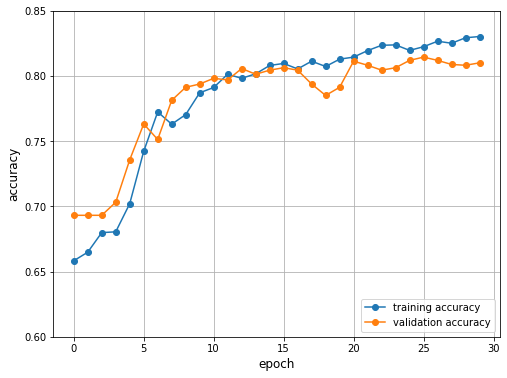

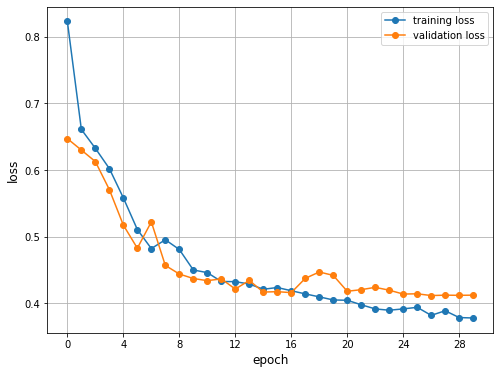

In [30]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

plot_acc(cnn_record)
plot_loss(cnn_record)

63/63 - 4s - loss: 0.4340 - accuracy: 0.8035 - 4s/epoch - 60ms/step
0.8034999966621399


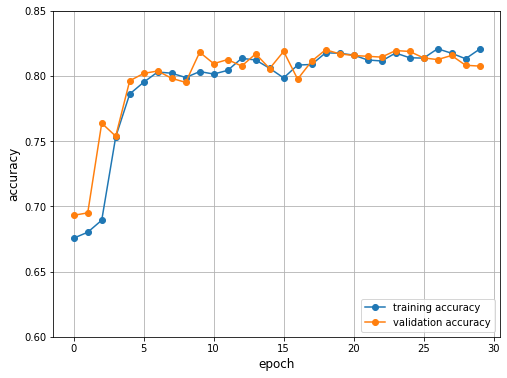

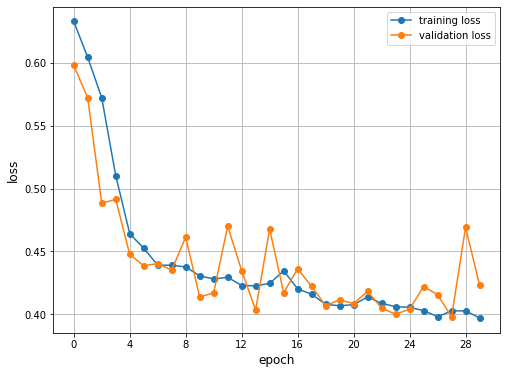

In [31]:
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

plot_acc(lstm_record)
plot_loss(lstm_record)